[View in Colaboratory](https://colab.research.google.com/github/dkatsios/semantic_segmentation/blob/master/voc2012.ipynb)

In [0]:
import numpy as np
import os
from shutil import unpack_archive
import cv2
from matplotlib import pyplot as plt
from IPython.display import Image
import PIL
from keras.optimizers import Adam
from time import time
from google.colab import files
from keras.models import load_model

### Download VOC 2012 dataset

In [0]:
# %mkdir semantic_segmentation
# %cd semantic_segmentation/
# !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
# unpack_archive('VOCtrainval_11-May-2012.tar', './')

In [1]:
%cd /content/semantic_segmentation/VOCdevkit/VOC2012
!ls

[Errno 2] No such file or directory: '/content/semantic_segmentation/VOCdevkit/VOC2012'
/content
datalab


In [0]:
imgs_folder = './JPEGImages/'
classes_folder = './SegmentationClass/'
train_list_path = './ImageSets/Segmentation/train.txt'
val_list_path = './ImageSets/Segmentation/val.txt'

### Import helpers and Model files

In [0]:
files.upload()

In [0]:
from voc2012_helpers import *
from atrusunet import  *

### Set parameters

In [0]:
img_shape = 512, 512, 3
filters = 64
segmentation_classes = 21
steps = 5
out_resized_levels = 4
kernel_sizes = [2, 3, 5]
batch_size = 4
epochs = 7
val_steps = 10

### Build generators

In [50]:
# train_lists, val_lists = get_lists_from_folders(train_list_path, val_list_path, imgs_folder, classes_folder)
# train_arrays = get_imgs_classes_arrays(*train_lists, img_shape)
# val_arrays = get_imgs_classes_arrays(*val_lists, img_shape)
# steps_per_epoch= len(train_lists[0]) // batch_size

start constructing arrays
arrays constructed. time: 76 secs
start constructing arrays
arrays constructed. time: 76 secs


In [0]:
train_gen = imgs_generator(*train_arrays, batch_size, out_resized_levels, segmentation_classes)
val_gen = imgs_generator(*val_arrays, batch_size, out_resized_levels, segmentation_classes)

### Build model

In [52]:
atrous_unet = AtrousUnet(img_shape, filters, segmentation_classes,
                         steps, out_resized_levels, kernel_sizes)

atrous_unet.build_model()
print('number of parameters:', atrous_unet.model.count_params())

number of parameters: 1955935


### Compile model

In [0]:
optimizer = Adam(0.001)

losses = ['categorical_crossentropy'] * (out_resized_levels + 1)  # mse
atrous_unet.model.compile(optimizer=optimizer, loss=losses, metrics=['categorical_accuracy'])

### Train model

In [54]:
class_weight = {key:1/segmentation_classes if key < segmentation_classes
                else 0 for key in range(segmentation_classes + 1)}

history = atrous_unet.model.fit_generator(train_gen,
                                          steps_per_epoch=steps_per_epoch, epochs=epochs,
                                          verbose=1, validation_data=val_gen, validation_steps=val_steps,
                                          class_weight=class_weight)

Epoch 1/7
229/366 [=================>............] - ETA: 3:12 - loss: 22.7000 - out_sampled_4_loss: 5.2540 - out_sampled_2_loss: 5.2038 - out_sampled_1_loss: 4.7789 - out_sampled_0_loss: 4.3759 - out_img_loss: 3.0873 - out_sampled_4_categorical_accuracy: 0.6729 - out_sampled_2_categorical_accuracy: 0.6697 - out_sampled_1_categorical_accuracy: 0.6513 - out_sampled_0_categorical_accuracy: 0.6299 - out_img_categorical_accuracy: 0.6317

366/366 [==============================] - 516s 1s/step - loss: 20.0392 - out_sampled_4_loss: 5.2377 - out_sampled_2_loss: 4.8547 - out_sampled_1_loss: 3.8395 - out_sampled_0_loss: 3.4639 - out_img_loss: 2.6434 - out_sampled_4_categorical_accuracy: 0.6729 - out_sampled_2_categorical_accuracy: 0.6694 - out_sampled_1_categorical_accuracy: 0.6516 - out_sampled_0_categorical_accuracy: 0.6409 - out_img_categorical_accuracy: 0.6497 - val_loss: 12.6993 - val_out_sampled_4_loss: 4.7861 - val_out_sampled_2_loss: 3.0163 - val_out_sampled_1_loss: 1.6314 - val_out_sampled_0_loss: 1.5747 - val_out_img_loss: 1.6909 - val_out_sampled_4_categorical_accuracy: 0.7021 - val_out_sampled_2_categorical_accuracy: 0.6012 - val_out_sampled_1_categorical_accuracy: 0.6912 - val_out_sampled_0_categorical_accuracy: 0.6952 - val_out_img_categorical_accuracy: 0.7000
Epoch 2/7
 31/366 [=>............................] - ETA: 7:40 - loss: 14.7295 - out_sampled_4_loss: 5.6956 - out_sampled_2_loss: 2.8458 - out_sampled_1

264/366 [====================>.........] - ETA: 2:20 - loss: 12.0607 - out_sampled_4_loss: 4.9938 - out_sampled_2_loss: 1.8848 - out_sampled_1_loss: 1.6919 - out_sampled_0_loss: 1.7143 - out_img_loss: 1.7759 - out_sampled_4_categorical_accuracy: 0.6873 - out_sampled_2_categorical_accuracy: 0.6761 - out_sampled_1_categorical_accuracy: 0.6814 - out_sampled_0_categorical_accuracy: 0.6797 - out_img_categorical_accuracy: 0.6739

366/366 [==============================] - 508s 1s/step - loss: 11.9336 - out_sampled_4_loss: 5.0187 - out_sampled_2_loss: 1.7898 - out_sampled_1_loss: 1.6668 - out_sampled_0_loss: 1.6903 - out_img_loss: 1.7679 - out_sampled_4_categorical_accuracy: 0.6865 - out_sampled_2_categorical_accuracy: 0.6779 - out_sampled_1_categorical_accuracy: 0.6787 - out_sampled_0_categorical_accuracy: 0.6773 - out_img_categorical_accuracy: 0.6724 - val_loss: 10.0532 - val_out_sampled_4_loss: 4.4195 - val_out_sampled_2_loss: 1.3108 - val_out_sampled_1_loss: 1.3675 - val_out_sampled_0_loss: 1.4720 - val_out_img_loss: 1.4834 - val_out_sampled_4_categorical_accuracy: 0.7258 - val_out_sampled_2_categorical_accuracy: 0.7253 - val_out_sampled_1_categorical_accuracy: 0.7243 - val_out_sampled_0_categorical_accuracy: 0.7164 - val_out_img_categorical_accuracy: 0.7242
Epoch 3/7
 42/366 [==>...........................] - ETA: 7:24 - loss: 10.5638 - out_sampled_4_loss: 4.6263 - out_sampled_2_loss: 1.4043 - out_sampled_1

275/366 [=====================>........] - ETA: 2:05 - loss: 10.9786 - out_sampled_4_loss: 4.8462 - out_sampled_2_loss: 1.4456 - out_sampled_1_loss: 1.5104 - out_sampled_0_loss: 1.5191 - out_img_loss: 1.6574 - out_sampled_4_categorical_accuracy: 0.6993 - out_sampled_2_categorical_accuracy: 0.6966 - out_sampled_1_categorical_accuracy: 0.6897 - out_sampled_0_categorical_accuracy: 0.6888 - out_img_categorical_accuracy: 0.6826

366/366 [==============================] - 508s 1s/step - loss: 11.0821 - out_sampled_4_loss: 4.8925 - out_sampled_2_loss: 1.4553 - out_sampled_1_loss: 1.5193 - out_sampled_0_loss: 1.5242 - out_img_loss: 1.6909 - out_sampled_4_categorical_accuracy: 0.6965 - out_sampled_2_categorical_accuracy: 0.6941 - out_sampled_1_categorical_accuracy: 0.6876 - out_sampled_0_categorical_accuracy: 0.6869 - out_img_categorical_accuracy: 0.6812 - val_loss: 12.3776 - val_out_sampled_4_loss: 5.6586 - val_out_sampled_2_loss: 1.5946 - val_out_sampled_1_loss: 1.6543 - val_out_sampled_0_loss: 1.6116 - val_out_img_loss: 1.8585 - val_out_sampled_4_categorical_accuracy: 0.6489 - val_out_sampled_2_categorical_accuracy: 0.6469 - val_out_sampled_1_categorical_accuracy: 0.6355 - val_out_sampled_0_categorical_accuracy: 0.6423 - val_out_img_categorical_accuracy: 0.6402
Epoch 4/7
 46/366 [==>...........................] - ETA: 7:20 - loss: 11.8009 - out_sampled_4_loss: 5.2864 - out_sampled_2_loss: 1.5070 - out_sampled_1

279/366 [=====================>........] - ETA: 1:59 - loss: 10.8000 - out_sampled_4_loss: 4.8348 - out_sampled_2_loss: 1.4023 - out_sampled_1_loss: 1.4641 - out_sampled_0_loss: 1.4751 - out_img_loss: 1.6237 - out_sampled_4_categorical_accuracy: 0.7000 - out_sampled_2_categorical_accuracy: 0.6986 - out_sampled_1_categorical_accuracy: 0.6945 - out_sampled_0_categorical_accuracy: 0.6943 - out_img_categorical_accuracy: 0.6898

366/366 [==============================] - 508s 1s/step - loss: 10.7766 - out_sampled_4_loss: 4.8391 - out_sampled_2_loss: 1.3995 - out_sampled_1_loss: 1.4599 - out_sampled_0_loss: 1.4703 - out_img_loss: 1.6078 - out_sampled_4_categorical_accuracy: 0.6998 - out_sampled_2_categorical_accuracy: 0.6984 - out_sampled_1_categorical_accuracy: 0.6944 - out_sampled_0_categorical_accuracy: 0.6943 - out_img_categorical_accuracy: 0.6905 - val_loss: 9.8907 - val_out_sampled_4_loss: 4.3723 - val_out_sampled_2_loss: 1.2878 - val_out_sampled_1_loss: 1.3533 - val_out_sampled_0_loss: 1.3460 - val_out_img_loss: 1.5313 - val_out_sampled_4_categorical_accuracy: 0.7287 - val_out_sampled_2_categorical_accuracy: 0.7268 - val_out_sampled_1_categorical_accuracy: 0.7266 - val_out_sampled_0_categorical_accuracy: 0.7256 - val_out_img_categorical_accuracy: 0.7284
Epoch 5/7
 47/366 [==>...........................] - ETA: 7:17 - loss: 11.5802 - out_sampled_4_loss: 5.1294 - out_sampled_2_loss: 1.4910 - out_sampled_1_

280/366 [=====================>........] - ETA: 1:58 - loss: 11.3903 - out_sampled_4_loss: 5.1841 - out_sampled_2_loss: 1.4609 - out_sampled_1_loss: 1.5315 - out_sampled_0_loss: 1.5277 - out_img_loss: 1.6861 - out_sampled_4_categorical_accuracy: 0.6784 - out_sampled_2_categorical_accuracy: 0.6766 - out_sampled_1_categorical_accuracy: 0.6709 - out_sampled_0_categorical_accuracy: 0.6716 - out_img_categorical_accuracy: 0.6675

366/366 [==============================] - 507s 1s/step - loss: 11.1680 - out_sampled_4_loss: 5.0837 - out_sampled_2_loss: 1.4375 - out_sampled_1_loss: 1.5018 - out_sampled_0_loss: 1.5002 - out_img_loss: 1.6449 - out_sampled_4_categorical_accuracy: 0.6846 - out_sampled_2_categorical_accuracy: 0.6828 - out_sampled_1_categorical_accuracy: 0.6778 - out_sampled_0_categorical_accuracy: 0.6784 - out_img_categorical_accuracy: 0.6745 - val_loss: 11.1298 - val_out_sampled_4_loss: 5.0731 - val_out_sampled_2_loss: 1.4300 - val_out_sampled_1_loss: 1.5103 - val_out_sampled_0_loss: 1.5244 - val_out_img_loss: 1.5920 - val_out_sampled_4_categorical_accuracy: 0.6853 - val_out_sampled_2_categorical_accuracy: 0.6846 - val_out_sampled_1_categorical_accuracy: 0.6800 - val_out_sampled_0_categorical_accuracy: 0.6803 - val_out_img_categorical_accuracy: 0.6839
Epoch 6/7
 48/366 [==>...........................] - ETA: 7:16 - loss: 11.4607 - out_sampled_4_loss: 5.2892 - out_sampled_2_loss: 1.4600 - out_sampled_1

281/366 [======================>.......] - ETA: 1:56 - loss: 10.8489 - out_sampled_4_loss: 4.9996 - out_sampled_2_loss: 1.3885 - out_sampled_1_loss: 1.4345 - out_sampled_0_loss: 1.4399 - out_img_loss: 1.5864 - out_sampled_4_categorical_accuracy: 0.6898 - out_sampled_2_categorical_accuracy: 0.6873 - out_sampled_1_categorical_accuracy: 0.6848 - out_sampled_0_categorical_accuracy: 0.6852 - out_img_categorical_accuracy: 0.6818

366/366 [==============================] - 507s 1s/step - loss: 10.6887 - out_sampled_4_loss: 4.9204 - out_sampled_2_loss: 1.3745 - out_sampled_1_loss: 1.4162 - out_sampled_0_loss: 1.4208 - out_img_loss: 1.5568 - out_sampled_4_categorical_accuracy: 0.6947 - out_sampled_2_categorical_accuracy: 0.6925 - out_sampled_1_categorical_accuracy: 0.6900 - out_sampled_0_categorical_accuracy: 0.6903 - out_img_categorical_accuracy: 0.6871 - val_loss: 10.0891 - val_out_sampled_4_loss: 4.6843 - val_out_sampled_2_loss: 1.3034 - val_out_sampled_1_loss: 1.3195 - val_out_sampled_0_loss: 1.3272 - val_out_img_loss: 1.4547 - val_out_sampled_4_categorical_accuracy: 0.7094 - val_out_sampled_2_categorical_accuracy: 0.7070 - val_out_sampled_1_categorical_accuracy: 0.6964 - val_out_sampled_0_categorical_accuracy: 0.6986 - val_out_img_categorical_accuracy: 0.6930
Epoch 7/7
 48/366 [==>...........................] - ETA: 7:15 - loss: 10.6275 - out_sampled_4_loss: 4.8417 - out_sampled_2_loss: 1.3736 - out_sampled_1

281/366 [======================>.......] - ETA: 1:56 - loss: 10.5933 - out_sampled_4_loss: 4.8809 - out_sampled_2_loss: 1.3641 - out_sampled_1_loss: 1.4124 - out_sampled_0_loss: 1.4145 - out_img_loss: 1.5214 - out_sampled_4_categorical_accuracy: 0.6971 - out_sampled_2_categorical_accuracy: 0.6952 - out_sampled_1_categorical_accuracy: 0.6918 - out_sampled_0_categorical_accuracy: 0.6919 - out_img_categorical_accuracy: 0.6904

366/366 [==============================] - 507s 1s/step - loss: 10.5679 - out_sampled_4_loss: 4.8751 - out_sampled_2_loss: 1.3586 - out_sampled_1_loss: 1.4081 - out_sampled_0_loss: 1.4084 - out_img_loss: 1.5178 - out_sampled_4_categorical_accuracy: 0.6975 - out_sampled_2_categorical_accuracy: 0.6956 - out_sampled_1_categorical_accuracy: 0.6921 - out_sampled_0_categorical_accuracy: 0.6924 - out_img_categorical_accuracy: 0.6901 - val_loss: 11.0445 - val_out_sampled_4_loss: 5.1774 - val_out_sampled_2_loss: 1.4330 - val_out_sampled_1_loss: 1.4780 - val_out_sampled_0_loss: 1.4706 - val_out_img_loss: 1.4855 - val_out_sampled_4_categorical_accuracy: 0.6788 - val_out_sampled_2_categorical_accuracy: 0.6773 - val_out_sampled_1_categorical_accuracy: 0.6742 - val_out_sampled_0_categorical_accuracy: 0.6751 - val_out_img_categorical_accuracy: 0.6759


In [0]:
atrous_unet.model.save('atrous_unet_model_weights_7_epochs.h5')
files.download('atrous_unet_model_weights_7_epochs.h5')

In [0]:
# atrous_unet = AtrousUnet(img_shape, filters, segmentation_classes,
#                          steps, out_resized_levels, kernel_sizes)
# atrous_unet.build_model()
model = load_model('atrous_unet_model_weights_10_epochs.h5')

In [0]:
def get_cmap_dict(reversed=False):
  def color_map(N=256, normalized=False):
    
    def bitget(byteval, idx):
        return ((byteval & (1 << idx)) != 0)

    dtype = 'float32' if normalized else 'uint8'
    cmap = np.zeros((N, 3), dtype=dtype)
    
    for i in range(N):
        r = g = b = 0
        c = i
        for j in range(8):
            r = r | (bitget(c, 0) << 7-j)
            g = g | (bitget(c, 1) << 7-j)
            b = b | (bitget(c, 2) << 7-j)
            c = c >> 3
        cmap[i] = np.array([r, g, b])
    cmap = cmap/255 if normalized else cmap
    return cmap
  
  cmap = color_map()
  cmap_dict = dict()
  for i in range(cmap.shape[0]):
    if reversed:
      cmap_dict[i] = cmap[i]
    else:
      cmap_dict[tuple(cmap[i].astype(np.int64))] = i
  return cmap_dict

In [0]:
def get_images_from_predictions(preds):
  cmap_dict = get_cmap_dict(reversed=True)
  preds = np.argmax(preds, axis=-1)
  imgs = np.zeros((*preds.shape, 3))
  for i, pred in enumerate(preds):
    for j in range(pred.shape[0]):
      for k in range(pred.shape[1]):
        imgs[i, j, k, :] = cmap_dict[pred[j, k]]
  
  return imgs

In [0]:
imgs, labels = val_gen.__next__()
predictions = atrous_unet.model.predict_on_batch(imgs)
pred_labels = predictions[-1]
pred_labels = get_images_from_predictions(pred_labels)

real_labels = labels[-1]
real_labels = get_images_from_predictions(real_labels)

255


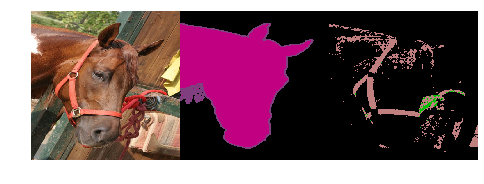

255


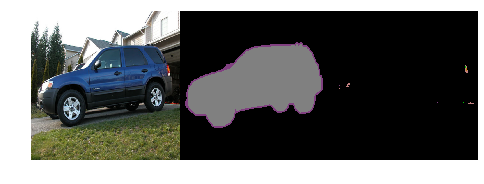

255


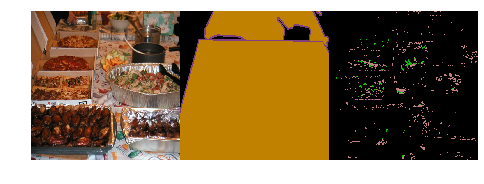

250


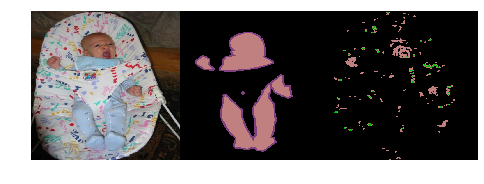

In [59]:
for img, real_label, pred_label in zip(imgs, real_labels, pred_labels):
  image = np.concatenate((img, real_label, pred_label), axis=1).astype(np.uint8)
  print(np.max(image))
#   image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(image)
  plt.axis('off')
  plt.show()